In [1]:


from cgi import test
from imghdr import tests
from re import X
import time
import pdb
import matplotlib.pyplot as plt
import numpy as np
import torch
from sklearn.metrics import mean_absolute_error, mean_squared_error
from torch.utils.data import DataLoader
from tqdm import *
from dataset import TimeSeriesDataset
from model import Forcast, lstm_seq2seq
from SCINet import SCINet
from sklearn.preprocessing import MinMaxScaler
from utils import plot_train_test_results

time_start = time.time()

params = {
    'history_step': 64,
    'forecast_step': 8,
    'hidden_size': 4,
    'num_layers': 2,
    'dropout_rate': 0.5,
    'epochs': 50,
    'batch_size': 8,
    'lr': 0.001,
    'train_pro':0.8,
    'dSample':10,
}

scaler = MinMaxScaler(feature_range=(-1, 1))
trainset = TimeSeriesDataset(params, 1, scaler)
testset = TimeSeriesDataset(params, params['forecast_step'], scaler)
train_len = trainset.__len__()
test_len = testset.__len__()

#pdb.set_trace()
X_train, Y_train, X_test, Y_test = None, None, None, None
for i in range(train_len):
    x, y = trainset.__getitem__(i)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    if i==0:
        X_train, Y_train = x, y
    else:
        X_train = torch.hstack((X_train, x))
        Y_train = torch.hstack((Y_train, y))
for i in range(test_len):
    x, y = testset.__getitem__(i)
    x = torch.from_numpy(x)
    y = torch.from_numpy(y)
    if i==0:
        X_test, Y_test = x, y
    else:
        X_test = torch.hstack((X_test, x))
        Y_test = torch.hstack((Y_test, y))

X_train = torch.unsqueeze(X_train, 2)
Y_train = torch.unsqueeze(Y_train, 2)
X_test = torch.unsqueeze(X_test, 2)
Y_test = torch.unsqueeze(Y_test, 2)

print(f' shape of x train, y train:\t{X_train.shape, Y_train.shape}\n')
print(f' shape of x test, y test:\t{X_test.shape, Y_test.shape}\n')


/home/sychen/anaconda3/envs/AI_for_6G/lib/python3.8/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


 shape of x train, y train:	(torch.Size([64, 2033, 1]), torch.Size([8, 2033, 1]))

 shape of x test, y test:	(torch.Size([64, 57, 1]), torch.Size([8, 57, 1]))



In [2]:
model = lstm_seq2seq(input_size=1, hidden_size=params['hidden_size'])

loss = model.train_model(X_train, Y_train, n_epochs = params['epochs'], target_len = params['forecast_step'],\
        batch_size = params['batch_size'], training_prediction = 'mixed_teacher_forcing',\
        teacher_forcing_ratio = 0.6, learning_rate = 0.01, dynamic_tf = False)

100%|██████████| 50/50 [04:19<00:00,  5.20s/it, loss=0.022]


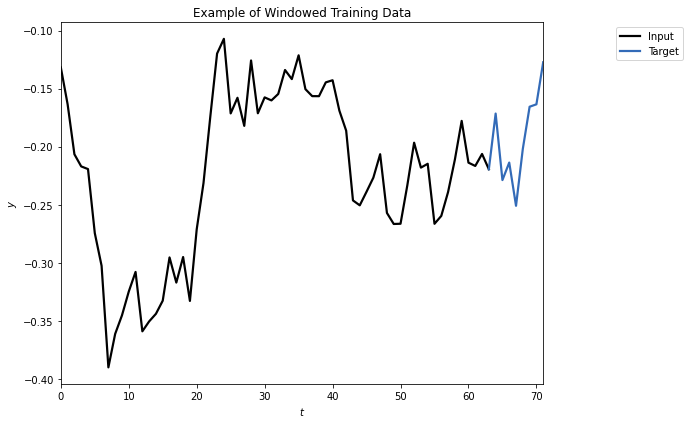

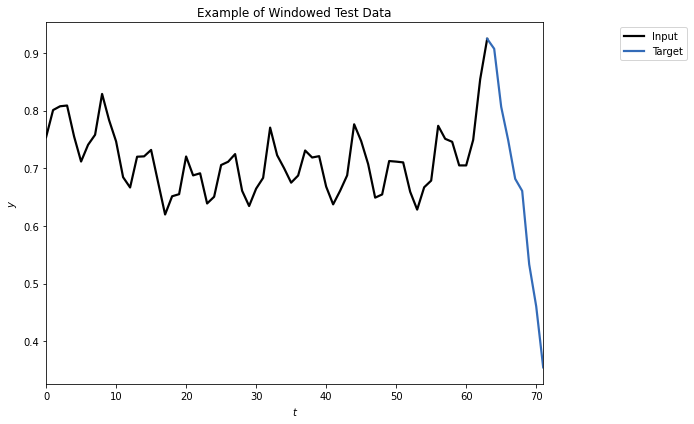

In [3]:
X_train, Y_train, X_test, Y_test = X_train.numpy(), Y_train.numpy(), X_test.numpy(), Y_test.numpy()


#plot the i_th sample of the train/test data
i_th = 18

iw = params['history_step']
ow = params['forecast_step']
plt.figure(figsize = (10, 6)) 
plt.plot(np.arange(0, iw), X_train[:, i_th, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[X_train[-1, i_th, 0]], Y_train[:, i_th, 0]]),
         color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Training Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout() 
plt.savefig('plots/windowed_data.png')


plt.figure(figsize = (10, 6))
plt.plot(np.arange(0, iw), X_test[:, i_th, 0], 'k', linewidth = 2.2, label = 'Input')
plt.plot(np.arange(iw - 1, iw + ow), np.concatenate([[X_test[-1, i_th, 0]], Y_test[:, i_th, 0]]),
            color = (0.2, 0.42, 0.72), linewidth = 2.2, label = 'Target')
plt.xlim([0, iw + ow - 1])
plt.xlabel(r'$t$')
plt.ylabel(r'$y$')
plt.title('Example of Windowed Test Data')
plt.legend(bbox_to_anchor=(1.3, 1))
plt.tight_layout()
plt.savefig('plots/windowed_test_data.png')

In [4]:

plot_train_test_results(model, X_train, Y_train, X_test, Y_test)